In [1]:
%%javascript
IPython.notebook.kernel.execute(`nb_name_full = '${IPython.notebook.notebook_name}'`);

<IPython.core.display.Javascript object>

In [5]:
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
from matplotlib import pyplot as plt

analysis_root = 'M:\\Subjects'
nb_name = nb_name_full.split('.')[0]
analysis_dir = os.path.join(analysis_root,nb_name)
if not os.path.isdir(analysis_dir): 
    os.makedirs(analysis_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#mov_path = 'Y:\\analysis\\AH007_2022-03-24\\s3d-AH007_2022-04-26_1-2-3-4-5-6\\registered_fused_data\\fused_reg_data0000.npy'
mov_path = 'M:/Subjects/SP035/2023-03-03/001/alf/suite2p/plane0/data.bin'

In [32]:
reg_binary = np.fromfile(mov_path,dtype='int16')

In [37]:
example_movie = np.reshape(reg_binary,[33170,512,512])


In [38]:
# example_movie should be a numpy array of dtype int16
# with shape nt, ny, nx where nt is the number of framex, ny,nx are the frame size in pixels

Text(0.5, 1.0, 'Example Frame')

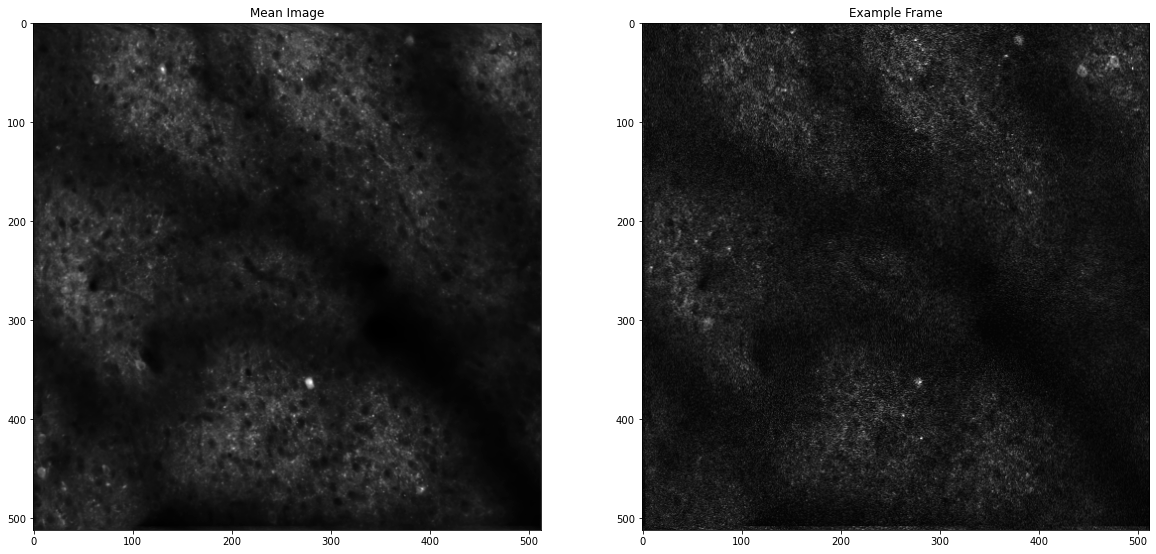

In [39]:
f,axs = plt.subplots(1,2, figsize=(20,10))
axs[0].imshow(example_movie.mean(axis=0), cmap='Greys_r')#, vmin=0, vmax=500)
axs[0].grid(False)
axs[0].set_title("Mean Image")
axs[1].imshow(example_movie[100], cmap='Greys_r')#, vmin=0, vmax=500)
axs[1].grid(False)
axs[1].set_title("Example Frame")

In [42]:
#import suite2p.detection.svd_utils as svu
import svd_utils as svu
from dask import array as darr

In [43]:
# we need to convert it into a dask array, and since my code is for 3d we 
# need to add an extra placeholder dimension of size 1 at the beginning 

In [44]:
movie_dask = darr.array(example_movie[np.newaxis])
movie_dask

dask.array<array, shape=(1, 33170, 512, 512), dtype=int16, chunksize=(1, 310, 256, 256), chunktype=numpy.ndarray>

In [45]:
# this splits the movie into spatial blocks and runs svd decomposition
# block_shape is the size of each block in all three dimensions (set first to 1 for 2D data)
# block_overlaps sets the # pix overlapping between blocks in each dimension, but set this to 0 
#                for now because the reconstruction code doesn't account for the overlaps yet
# n_comp is the number of SVD components to keep PER BLOCK. I set this to low since my example 
#                movie is only 200 frames
# pix_chunk should be a multiple of the product of elements of block_shape
# svd_dir is the directory to save the SVD components to

In [ ]:
svd_info = svu.block_and_svd(movie_dask, n_comp = 50, block_shape = (1,128,128), block_overlaps=(0,0,0),
                 svd_dir= analysis_dir, pix_chunk = 256*256, n_svd_blocks_per_batch=8)

Will compute SVD in 16 blocks in a grid shaped (1, 4, 4)
Batching 8 blocks together, for a total of 2 batches
Saving SVD blocks in M:\Subjects\svd_denoise_example\blocks
Starting batch 1 / 2, blocks 0 - 8
Sending batch 1 to dask
Dask completed in 107.438 sec
Saving svd_info to M:\Subjects\svd_denoise_example\svd_info.npy
Batch 1 completed in 110.991
Estimated time remaining for 1 batches: 00h01m50s
Starting batch 2 / 2, blocks 8 - 16
Sending batch 2 to dask


In [50]:
# this loads back the saved components and creates a memory-mapped dask array
# that is the reconstructed movie. It doesn't actually reconstruct! For that,
# you need to call .compute() on it
# note the second dimension of size 1 is the z dimension which you don't care about

In [51]:
reconstructed_movie_dask = svu.reconstruct_movie(analysis_dir)

AttributeError: 'FSMap' object has no attribute 'check'

In [52]:
reconstructed_movie_dask

NameError: name 'reconstructed_movie_dask' is not defined

In [55]:
reconstructed_movie = reconstructed_movie_dask.compute()[:,0]

Text(0.5, 1.0, 'Denoised Example Frame')

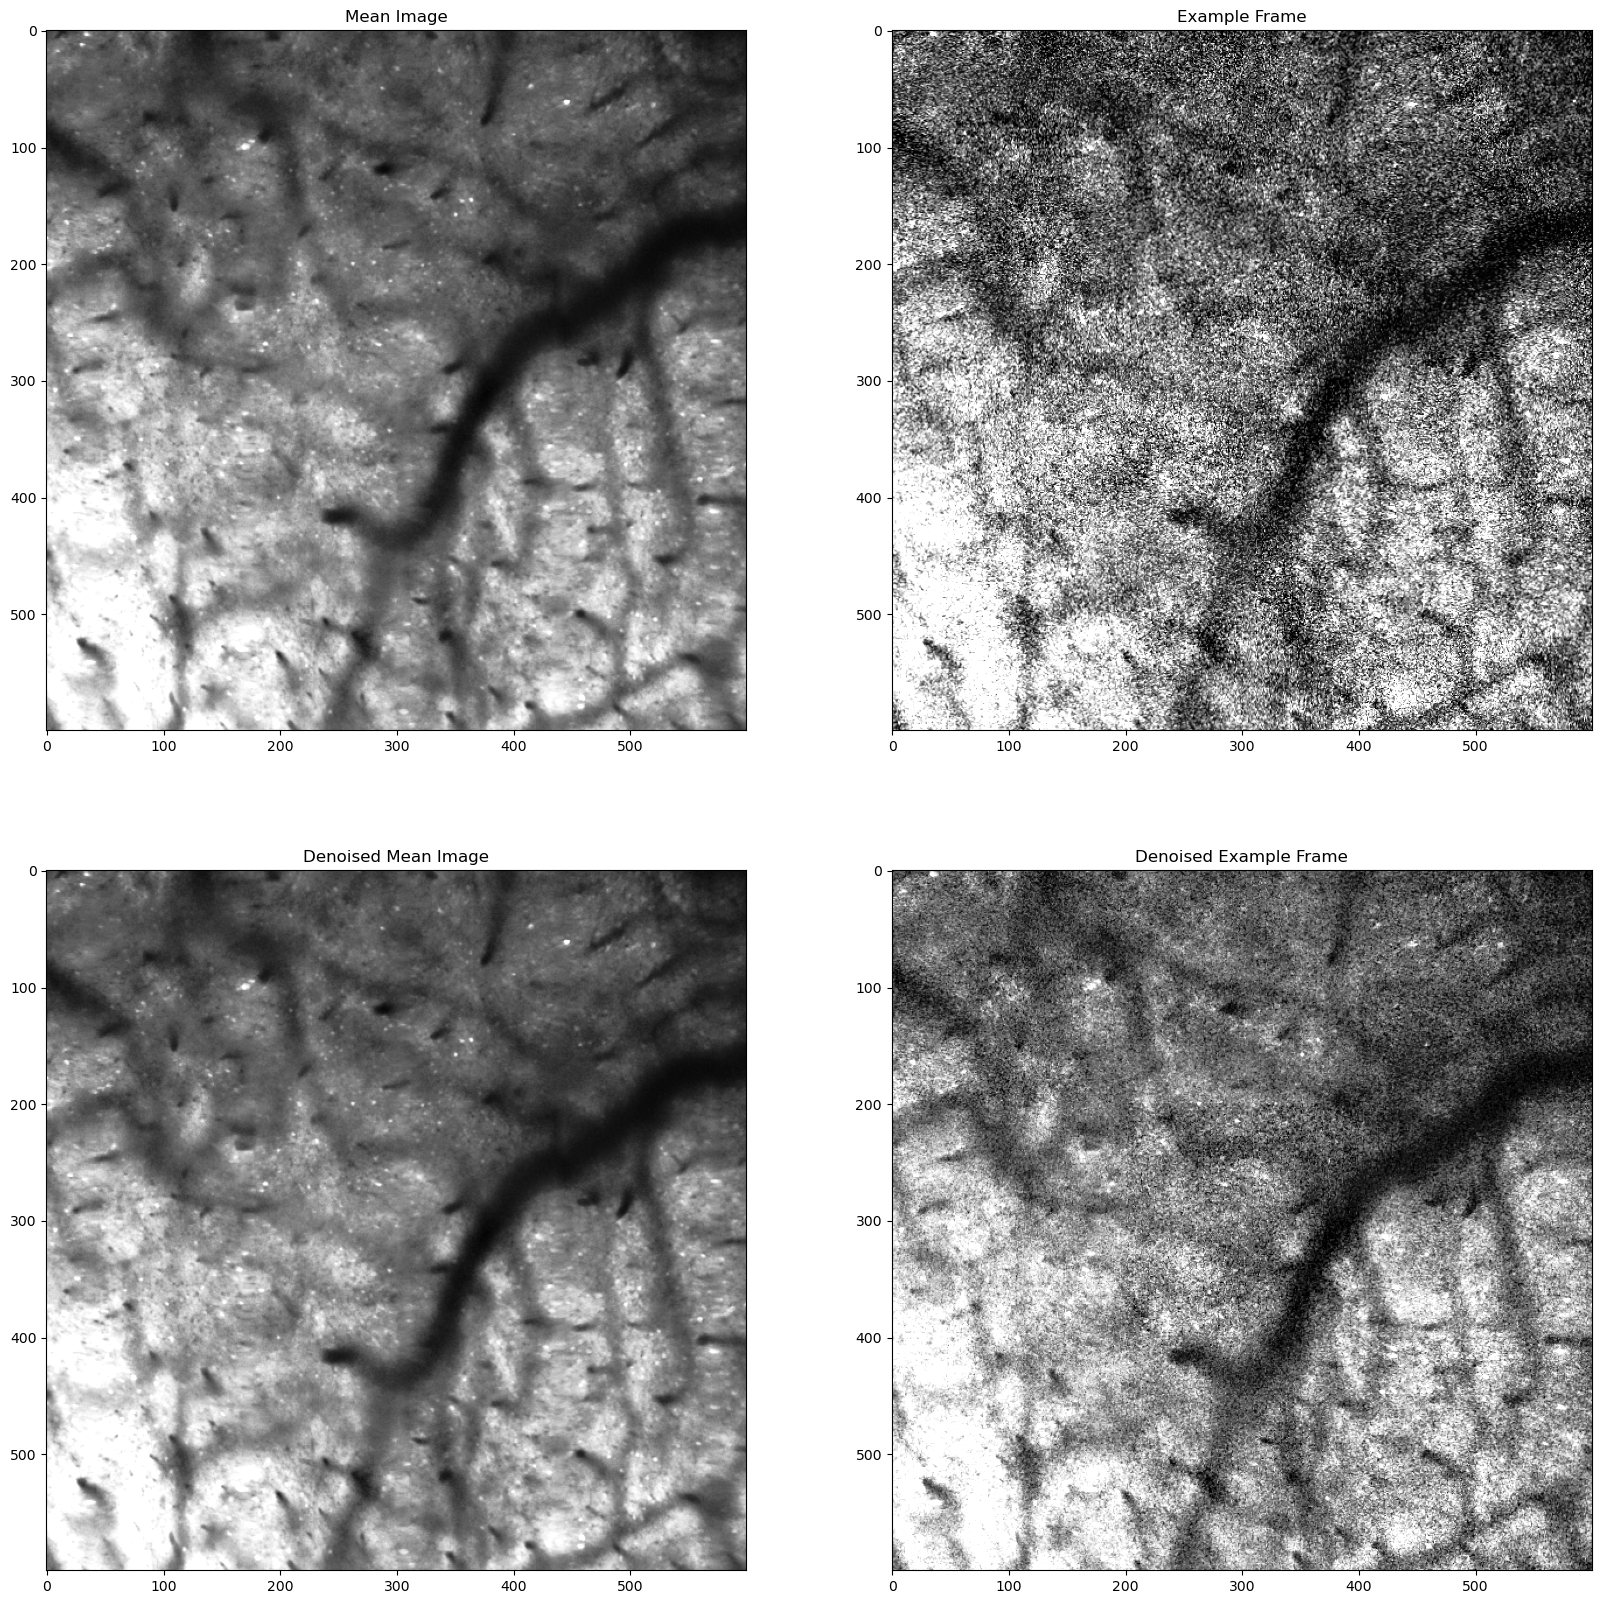

In [56]:
f,axs = plt.subplots(2,2, figsize=(20,20))
axs[0][0].imshow(example_movie.mean(axis=0), cmap='Greys_r', vmin=0, vmax=500)
axs[0][0].grid(False)
axs[0][0].set_title("Mean Image")
axs[0][1].imshow(example_movie[100], cmap='Greys_r', vmin=0, vmax=500)
axs[0][1].grid(False)
axs[0][1].set_title("Example Frame")
axs[1][0].imshow(reconstructed_movie.mean(axis=0), cmap='Greys_r', vmin=0, vmax=500)
axs[1][0].grid(False)
axs[1][0].set_title("Denoised Mean Image")
axs[1][1].imshow(reconstructed_movie[100], cmap='Greys_r', vmin=0, vmax=500)
axs[1][1].grid(False)
axs[1][1].set_title("Denoised Example Frame")